In [1]:
# python 3.10.2 
import sys
import os
import string
import collections
import re                       # 2.2.1
import numpy as np              # 1.22.0
import scipy                    # 1.7.2
import pandas as pd             # 1.3.4
import sklearn                  # 1.1.1
import sklearn.model_selection
import sklearn.tree
import gensim                   # 4.2.0
import nltk                     # 3.2.2
import torch                    # 1.12.0+cpu
import pytorch_pretrained_bert  # 0.6.2

In [2]:
print('python: {}'.format(sys.version))
print('{}: {}'.format(re.__name__, re.__version__))
print('{}: {}'.format(np.__name__, np.__version__))
print('{}: {}'.format(scipy.__name__, scipy.__version__))
print('{}: {}'.format(pd.__name__, pd.__version__))
print('{}: {}'.format(sklearn.__name__, sklearn.__version__))
print('{}: {}'.format(gensim.__name__, gensim.__version__))
print('{}: {}'.format(nltk.__name__, nltk.__version__))
print('{}: {}'.format(torch.__name__, torch.__version__))
print('{}: {}'.format(pytorch_pretrained_bert.__name__, pytorch_pretrained_bert.__version__))

python: 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
re: 2.2.1
numpy: 1.23.0
scipy: 1.8.1
pandas: 1.3.4
sklearn: 1.1.1
gensim: 4.2.0
nltk: 3.2.2
torch: 1.12.0+cpu
pytorch_pretrained_bert: 0.6.2


In [3]:
from IPython.display import display

FNC_DATA_PATH = '../fnc-1/'
GOOGLE_NEWS_WORD2VEC_MODEL_PATH = '../word2vec model/GoogleNews-vectors-negative300.bin.gz'

In [4]:
from data import FncData
from preprocessing import Preprocessor
from tokenization import WordTokenizer, SentenceTokenizer
from evaluation import Evaluator

In [5]:
bodies_csv_path = os.path.join(FNC_DATA_PATH, 'train_bodies.csv')
stances_csv_path = os.path.join(FNC_DATA_PATH, 'train_stances.csv')

In [6]:
fnc_data = FncData(bodies_csv_path, stances_csv_path)
fnc_data.splitIntoTrainAndTest()

In [7]:
# Used to create faster models
fnc_data_short = FncData(bodies_csv_path, stances_csv_path, max_length=500)
fnc_data_short.splitIntoTrainAndTest()

In [8]:
fnc_data.bodies

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
...,...,...
1678,2528,Intelligence agencies hunting for identity of ...
1679,2529,"While Daleks ""know no fear"" and ""must not fear..."
1680,2530,More than 200 schoolgirls were kidnapped in Ap...
1681,2531,A Guantanamo Bay prisoner released last year a...


In [9]:
fnc_data.headlines_and_stances

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
...,...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,1681,unrelated
49968,Brian Williams slams social media for speculat...,2419,unrelated
49969,Mexico Says Missing Students Not Found In Firs...,1156,agree
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,1012,discuss


In [10]:
fnc_data.headlines_bodies_and_stances

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\r\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\r\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\r\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\r\n...
...,...,...,...,...
49967,Amazon Is Opening a Brick-and-Mortar Store in ...,464,agree,"Amazon, the cyber store that sells everything,..."
49968,Elon University has not banned the term ‘fresh...,362,agree,"ELON, N.C. – A recent rumor claims that Elon U..."
49969,Fake BBC News website set up to carry Charlie ...,915,agree,A realistic-looking fake BBC News website has ...
49970,Apple was forced to nix key health features fr...,407,discuss,The health-focused smartwatch that Apple initi...


In [11]:
fnc_data.headlines_and_bodies_train.head()

,Headline,articleBody
34981,Audio recording allegedly captures at least 10...,A second patient with Ebola symptoms walked in...
25281,Batmobile Stolen From 'Batman V Superman: Dawn...,Apple is hosting its ‘Spring Forward’ event to...
7980,India Rape Crisis Sees Mob Castrate Alleged Se...,(CNN) -- The mystery surrounding North Korea's...
31462,Batmobile Stolen From 'Batman V Superman: Dawn...,"I don’t know if you heard, but supposedly an a..."
23791,Mexico hit by student massacre: At least 17 an...,Although the majority of Austrian resorts are ...


In [12]:
fnc_data.stances_train.head()

,Stance
34981,unrelated
25281,unrelated
7980,unrelated
31462,discuss
23791,unrelated


# Features

In [13]:
class FeatureExtractor:
    
    def extract(self, cache=False):
        raise NotImplementedError('Abstract method FeatureExtractor.extract is not implemented.')

In [14]:
FEATURE_EXTRACTORS = dict()

### Word2Vec

In [15]:
class Word2VecFeature:

    def __init__(self):
        self.google_news_word2vec_model = \
            gensim.models.KeyedVectors.load_word2vec_format(
                GOOGLE_NEWS_WORD2VEC_MODEL_PATH, binary=True)
        self.preprocessor = Preprocessor()
        self.word_tokenizer = WordTokenizer()
        return

    def hasWord(self, word):
        return word in self.google_news_word2vec_model.key_to_index
        return 

    def getVectors(self, text):
        processed_text = self.preprocessor.preprocess(text)
        words = self.word_tokenizer.tokenize(processed_text)
        # remove out-of-vocabulary words
        vocabulary_words = [word for word in words if self.hasWord(word)]
        return self.google_news_word2vec_model[vocabulary_words]

    def getMeanOfVectors(self, text):
        return np.mean(self.getVectors(text), axis=0)

    def get(self, text):
        return self.getMeanOfVectors(text)

In [16]:
class Word2VecCosineSimilarity(FeatureExtractor):

    FeatureName = 'Word2VecCosineSimilarity'

    def __init__(self, fnc_data, word2vec_feature):
        self.fnc_data = fnc_data
        self.word2vec = word2vec_feature
        return

    def getVector(self, headlines_and_bodies_data_frame, column, cache=False):
        if cache and column + 'Vector' in self.fnc_data.cache:
            return self.fnc_data.cache[column + 'Vector']
        vector = headlines_and_bodies_data_frame[column].apply(word2vec.get)
        if cache:
            self.fnc_data.cache[column + 'Vector'] = vector
        return vector

    def cosineSimilarity(self, vector1, vector2):
        return 1 - scipy.spatial.distance.cosine(vector1, vector2)

    def extractFeaturesFromDataFrame(self, headlines_and_bodies_data_frame, \
            cache=False):
        if self.FeatureName in headlines_and_bodies_data_frame:
            return
        vectors = pd.DataFrame()
        vectors['Headline'] = self.getVector(
            headlines_and_bodies_data_frame, 'Headline', cache)
        vectors['articleBody'] = self.getVector(
            headlines_and_bodies_data_frame, 'articleBody', cache)
        headlines_and_bodies_data_frame[self.FeatureName] = \
            vectors.apply(lambda row: self.cosineSimilarity(
                row['Headline'], row['articleBody']),
                axis=1
            )
        return

    def extract(self, cache=False):
        self.extractFeaturesFromDataFrame(
            self.fnc_data.headlines_and_bodies_train, cache)
        self.extractFeaturesFromDataFrame(
            self.fnc_data.headlines_and_bodies_test, cache)
        return

In [17]:
word2vec = Word2VecFeature()

In [18]:
text = fnc_data.headlines_and_bodies_train.iloc[0]['Headline']
text

'Audio recording allegedly captures at least 10 shots fired in Michael Brown killing'

In [19]:
word2vec.get(text)

array([ 2.58449987e-02,  1.46124944e-01,  1.70355905e-02, -8.19371566e-02,
        5.49248606e-02, -4.75836843e-02, -8.05664062e-03, -1.37044266e-01,
        1.20496958e-01,  1.72458231e-01, -4.08528633e-02, -2.21177846e-01,
       -2.31391061e-02,  3.67567269e-03, -2.73301862e-02, -1.44314235e-02,
       -4.37554270e-02,  1.53917104e-01, -7.19061941e-02, -1.36840820e-01,
       -5.86751290e-02,  8.62969309e-02, -2.92426217e-02, -7.73111999e-04,
       -3.09516061e-02, -9.57811177e-02, -1.18231878e-01,  8.02476704e-02,
        1.06092662e-01, -4.21888568e-02, -4.60747629e-02, -4.34027781e-04,
       -5.85293248e-02, -1.26139326e-02, -8.46015103e-03,  1.22070312e-03,
       -1.56317819e-02,  1.01996530e-02, -1.17458766e-02,  1.15464956e-01,
        4.94249128e-02,  1.63845494e-02,  1.41343862e-01, -9.19325054e-02,
        5.72916679e-02, -8.71158168e-02, -5.47154760e-03, -1.03095159e-01,
       -3.47222239e-02,  7.40424246e-02, -3.81741002e-02,  1.47840716e-02,
        1.16007484e-01, -

In [20]:
w2vcsfe = Word2VecCosineSimilarity(fnc_data, word2vec)
FEATURE_EXTRACTORS['Word2VecCosineSimilarity'] = w2vcsfe

### BERT - Bidirectional Encoder Representations from Transformers
https://arxiv.org/abs/1810.04805

In [21]:
class BertFeature:

    def __init__(self):
        self.tokenizer = pytorch_pretrained_bert.BertTokenizer. \
            from_pretrained('bert-base-uncased')
        self.model = pytorch_pretrained_bert.BertModel. \
            from_pretrained('bert-base-uncased')
        self.model.eval()
        return

    def get(self, text):
        marked_sentence = '[CLS] ' + text + ' [SEP]'
        tokenized_sentence = self.tokenizer.tokenize(marked_sentence)
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)
        segments_ids = [1] * len(indexed_tokens)
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])
        with torch.no_grad():
            encoded_layers, _ = self.model(tokens_tensor, segments_tensors)
        token_vectors = encoded_layers[11][0]
        bert_embedding = torch.mean(token_vectors, dim=0)
        return bert_embedding

In [22]:
class BertAverageSentenceCosineSimilarity(FeatureExtractor):

    FeatureName = 'BertAverageSentenceCosineSimilarity'

    def __init__(self, fnc_data, bert_feature):
        self.fnc_data = fnc_data
        self.bert = bert_feature
        self.sentence_tokenizer = SentenceTokenizer()
        return

    def getVector(self, headlines_and_bodies_data_frame, column, cache=False):
        if cache and column + 'Vector' in self.fnc_data.cache:
            return self.fnc_data.cache[column + 'Vector']
        vector = headlines_and_bodies_data_frame[column].apply(word2vec.get)
        if cache:
            self.fnc_data.cache[column + 'Vector'] = vector
        return vector

    def cosineSimilarity(self, vector1, vector2):
        return 1 - scipy.spatial.distance.cosine(vector1, vector2)

    def averageOneToNCosineSimilarity(self, base_vector, vectors):
        return np.average([self.cosineSimilarity(base_vector, vector) \
            for vector in vectors])

    def extractFeaturesFromRow(self, headlines_and_bodies_row):
        headline_vector = self.bert.get(headlines_and_bodies_row['Headline'])
        sentences = self.sentence_tokenizer.tokenize(
            headlines_and_bodies_row['articleBody'])
        body_vectors = [self.bert.get(sentence) for sentence in sentences]
        return self.averageOneToNCosineSimilarity(headline_vector, body_vectors)

    def extractFeaturesFromDataFrame(self, headlines_and_bodies_data_frame):
        if self.FeatureName in headlines_and_bodies_data_frame:
            return
        headlines_and_bodies_data_frame[self.FeatureName] = \
            headlines_and_bodies_data_frame.apply(lambda row:
                self.extractFeaturesFromRow(row), axis=1)
        return

    def extract(self, cache=False):
        self.extractFeaturesFromDataFrame(
            self.fnc_data.headlines_and_bodies_train)
        self.extractFeaturesFromDataFrame(
            self.fnc_data.headlines_and_bodies_test)
        return

In [23]:
bert = BertFeature()

In [24]:
text = fnc_data_short.headlines_and_bodies_train.iloc[0]['Headline']
text

'6 Islamist militants killed in US attack in Somalia'

In [25]:
bert.get(text)

tensor([-1.7162e-02, -2.0568e-01, -2.0299e-01, -1.2182e-01,  7.3556e-02,
        -1.3187e-02,  4.0842e-02,  3.7358e-01, -2.1771e-01,  3.9795e-02,
         4.9008e-02, -2.0608e-01, -1.0900e-01,  3.5545e-01, -8.4389e-01,
         2.8296e-01,  1.1935e-01, -1.6489e-01, -4.1526e-02,  4.2376e-01,
         5.5852e-01, -3.5291e-01,  1.9352e-01, -1.8408e-02,  3.8256e-01,
        -8.8013e-02,  2.2369e-01,  2.4910e-01, -9.1886e-02, -6.7511e-02,
         1.6466e-01, -7.1546e-02,  3.0062e-01,  1.3596e-01,  2.1311e-01,
         3.5493e-01, -2.2867e-01, -2.7568e-02, -5.3631e-02,  3.3778e-01,
        -3.5714e-01, -6.2078e-01, -2.9084e-01,  1.1770e-01, -1.2845e-01,
        -8.8845e-01,  2.5662e-01,  4.3566e-01, -2.2050e-01,  3.2750e-01,
        -3.8077e-02,  1.8733e-01, -2.2121e-01, -4.5713e-01,  4.1805e-01,
         7.1591e-01, -1.0438e-01, -1.2029e+00,  3.3178e-01, -3.7834e-01,
         3.1425e-01,  1.7272e-01,  3.5857e-01, -9.2569e-01,  2.3820e-01,
         3.6272e-02,  7.4793e-02,  6.4094e-01, -7.5

In [26]:
bascsfe = BertAverageSentenceCosineSimilarity(fnc_data_short, bert)
FEATURE_EXTRACTORS['BertAverageSentenceCosineSimilarity'] = bascsfe

### Term frequency – inverse document frequency

In [27]:
class TfIdfCosineSimilarity(FeatureExtractor):

    FeatureName = 'TfIdfCosineSimilarity'

    def __init__(self, fnc_data, ngram_range=(1, 1)):
        self.fnc_data = fnc_data
        self.preprocessor = Preprocessor()
        self.word_tokenizer = WordTokenizer()
        self.ngram_range = ngram_range
        self.tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
            preprocessor=self.preprocessor.preprocess,
            tokenizer=self.word_tokenizer.tokenize,
            ngram_range=self.ngram_range,
        )
        self.tfidf_vectors = None
        return

    def getTfIdfVectors(self, headlines_and_bodies_data_frame):
        if self.tfidf_vectors != None:
            return self.tfidf_vectors
        concatenated_headlines_and_bodies = pd.concat([
            headlines_and_bodies_data_frame['Headline'],
            headlines_and_bodies_data_frame['articleBody'],
        ])
        tfidf_vectors = self.tfidf_vectorizer.fit_transform(
            concatenated_headlines_and_bodies
        )
        self.tfidf_vectors = tfidf_vectors
        return self.tfidf_vectors

    def getHeadlineTfIdfVectors(self, headlines_and_bodies_data_frame, \
            cache=False):
        if cache and 'HeadlineTfIdfVector' in self.fnc_data.cache:
            return self.fnc_data.cache['HeadlineTfIdfVector']
        tfidf_vectors = self.getTfIdfVectors(headlines_and_bodies_data_frame)
        headline_tfidf_vectors = \
            tfidf_vectors[: headlines_and_bodies_data_frame.shape[0]]
        if cache:
            self.fnc_data.cache['HeadlineTfIdfVector'] = headline_tfidf_vectors
        return headline_tfidf_vectors

    def getBodyTfIdfVectors(self, headlines_and_bodies_data_frame, \
            cache=False):
        if cache and 'articleBodyTfIdfVector' in self.fnc_data.cache:
            return self.fnc_data.cache['articleBodyTfIdfVector']
        tfidf_vectors = self.getTfIdfVectors(headlines_and_bodies_data_frame)
        body_tfidf_vectors = \
            tfidf_vectors[headlines_and_bodies_data_frame.shape[0] :]
        if cache:
            self.fnc_data.cache['articleBodyTfIdfVector'] = body_tfidf_vectors
        return body_tfidf_vectors

    def cosineSimilarity(self, vector1, vector2):
        return 1 - scipy.spatial.distance.cosine(vector1, vector2)

    def extractFeaturesFromDataFrame(self, headlines_and_bodies_data_frame, \
            cache=False):
        self.tfidf_vectors = None
        if self.FeatureName in headlines_and_bodies_data_frame:
            return
        headline_tfidf_vectors = self.getHeadlineTfIdfVectors(
            headlines_and_bodies_data_frame, cache)
        body_tfidf_vectors = self.getBodyTfIdfVectors(
            headlines_and_bodies_data_frame, cache)
        tfidf_cosine_similarities = [tfidfcsfe.cosineSimilarity(
                headline_tfidf_vectors[i].toarray(),
                body_tfidf_vectors[i].toarray()
            ) for i in range(headlines_and_bodies_data_frame.shape[0])]
        headlines_and_bodies_data_frame[self.FeatureName] = \
            tfidf_cosine_similarities
        return

    def extract(self, cache=False):
        self.extractFeaturesFromDataFrame(
            self.fnc_data.headlines_and_bodies_train, cache)
        self.extractFeaturesFromDataFrame(
            self.fnc_data.headlines_and_bodies_test, cache)
        return

In [28]:
tfidfcsfe = TfIdfCosineSimilarity(fnc_data)
FEATURE_EXTRACTORS['TfIdfCosineSimilarity'] = tfidfcsfe

In [29]:
tfidfcsfe.extract()

In [30]:
i = 0
pd.concat([
        fnc_data.headlines_and_bodies_test.iloc[i : i + 1],
        fnc_data.stances_test.iloc[i : i + 1]
    ], axis=1
)

,Headline,articleBody,TfIdfCosineSimilarity,Stance
17851,"Apple Watch to Be Shower-Proof, Have 100,000 A...","PALM BEACH GARDENS, Fla. -- A journeyman profe...",0.0,unrelated


In [31]:
i = 6
pd.concat([
        fnc_data.headlines_and_bodies_test.iloc[i : i + 1],
        fnc_data.stances_test.iloc[i : i + 1]
    ], axis=1
)

,Headline,articleBody,TfIdfCosineSimilarity,Stance
49343,IS Militants Kill 300 Iraqi Soldiers with Chlo...,BAGHDAD — The Islamic State (IS) has been accu...,0.53067,discuss


In [32]:
i =8
pd.concat([
        fnc_data.headlines_and_bodies_test.iloc[i : i + 1],
        fnc_data.stances_test.iloc[i : i + 1]
    ], axis=1
)

,Headline,articleBody,TfIdfCosineSimilarity,Stance
49453,"No, Banksy has not been arrested (sigh)","London, England — The elusive graffiti artist,...",0.203024,disagree


In [33]:
i = 67
pd.concat([
        fnc_data.headlines_and_bodies_test.iloc[i : i + 1],
        fnc_data.stances_test.iloc[i : i + 1]
    ], axis=1
)

,Headline,articleBody,TfIdfCosineSimilarity,Stance
41105,"This boy nearly died, now he has a superpower ...",Nikolai Kryaglyachenko has suddenly started de...,0.101442,agree


### Names frequency (frequency of words not recognized by Word2Vec)

In [34]:
class NamesFrequency(FeatureExtractor):

    FeatureName = 'NamesFrequency'

    def __init__(self, fnc_data, word2vec_feature):
        self.fnc_data = fnc_data
        self.word2vec = word2vec_feature
        return

    def extractFeaturesFromRow(self, headlines_and_bodies_row):
        headlines_and_bodies_row['Headline']

        headlines_and_bodies_row['articleBody']

        processed_headline = self.word2vec.preprocessor.preprocess(
            headlines_and_bodies_row['Headline'])
        headline_words = self.word2vec.word_tokenizer.tokenize(
            processed_headline)
        processed_body = self.word2vec.preprocessor.preprocess(
            headlines_and_bodies_row['articleBody'])
        body_words = self.word2vec.word_tokenizer.tokenize(
            processed_body)
        non_vocabulary_headlines_words = [word for word in headline_words \
             if not self.word2vec.hasWord(word) and word.isalnum()]
        non_vocabulary_headlines_counter = collections.Counter()
        for word in body_words:
            if word in non_vocabulary_headlines_words:
                non_vocabulary_headlines_counter[word] += 1
        
        non_vocabulary_headlines_counts = np.array([
            non_vocabulary_headlines_counter[word] for word \
            in non_vocabulary_headlines_words
        ])
        
        non_vocabulary_headlines_frequencies = (non_vocabulary_headlines_counts
            / (len(headline_words) * len(body_words)))
        return np.sum(non_vocabulary_headlines_frequencies)

    def extractFeaturesFromDataFrame(self, headlines_and_bodies_data_frame):
        if self.FeatureName in headlines_and_bodies_data_frame:
            return
        headlines_and_bodies_data_frame[self.FeatureName] = \
            headlines_and_bodies_data_frame.apply(lambda row:
                self.extractFeaturesFromRow(row), axis=1)
        return

    def extract(self, cache=False):
        self.extractFeaturesFromDataFrame(
            self.fnc_data.headlines_and_bodies_train)
        self.extractFeaturesFromDataFrame(
            self.fnc_data.headlines_and_bodies_test)
        return

In [35]:
nffe = NamesFrequency(fnc_data, word2vec)
FEATURE_EXTRACTORS['NamesFrequency'] = nffe

In [36]:
nffe.extract()

In [37]:
i = 0
pd.concat([
        fnc_data.headlines_and_bodies_test.iloc[i : i + 1],
        fnc_data.stances_test.iloc[i : i + 1]
    ], axis=1
)

,Headline,articleBody,TfIdfCosineSimilarity,NamesFrequency,Stance
17851,"Apple Watch to Be Shower-Proof, Have 100,000 A...","PALM BEACH GARDENS, Fla. -- A journeyman profe...",0.0,0.0,unrelated


In [38]:
i = 116
pd.concat([
        fnc_data.headlines_and_bodies_test.iloc[i : i + 1],
        fnc_data.stances_test.iloc[i : i + 1]
    ], axis=1
)

,Headline,articleBody,TfIdfCosineSimilarity,NamesFrequency,Stance
1118,Macaulay Culkin Victim of Another Online Death...,Macaulay Culkin has once again died — at least...,0.508483,0.013661,agree


### Classifiers

In [39]:
class Classifier:

    Classes = ['agree', 'disagree', 'discuss', 'unrelated']

    def __init__(self):
        return

    def fit(self, headlines_and_bodies_train_features, stances_train):
        raise NotImplementedError('Abstract method Classifier.fit is not implemented.')
    
    def predict(self, headlines_and_bodies_train_features):
        raise NotImplementedError('Abstract method Classifier.predict is not implemented.')

    def evaluate(self, actual_stances, predicted_stance):
        correct = actual_stances == predicted_stance
        return np.sum(correct) / correct.size

    def getClassesArray(self):
        raise NotImplementedError('Abstract method Classifier.getClassesArray is not implemented.')

In [40]:
class DecisionTreeClassifier(Classifier):

    def __init__(self):
        self.decision_tree_classifier = sklearn.tree.DecisionTreeClassifier()
        return

    def fit(self, headlines_and_bodies_train_features, stances_train):
        self.decision_tree_classifier = self.decision_tree_classifier.fit(
            headlines_and_bodies_train_features, stances_train)
        return

    def predict(self, headlines_and_bodies_train_features):
        return self.decision_tree_classifier \
            .predict(headlines_and_bodies_train_features)

    def predict_proba(self, headlines_and_bodies_train_features):
        prediction_proba = self.decision_tree_classifier \
            .predict_proba(headlines_and_bodies_train_features)

        transposition_array = np.array([
            np.where(self.getClassesArray() == class_name)[0][0] \
                for class_name in self.getOrderedClasses()])
        prediction_proba = prediction_proba[:, transposition_array]
        return prediction_proba

    def getClassesArray(self):
        return self.decision_tree_classifier.classes_

    def getOrderedClasses(self):
        return [class_name for class_name in self.Classes \
            if class_name in self.getClassesArray()]


### Model creation

In [55]:
class  MachineLearningModel:

    def __init__(self, fnc_data, feature_extractors, classifiers, weights=None):
        self.fnc_data = fnc_data
        self.feature_extractors = feature_extractors
        self.classifiers = classifiers
        self.weights = weights or np.full(len(self.classifiers), \
            1 / len(self.classifiers))
        self.feature_names = [extractor.FeatureName for extractor \
            in self.feature_extractors]
        self.evaluator = Evaluator()
        self.prediction = None
        return

    def extractFeatures(self, cache=False):
        for feature_extractor in self.feature_extractors:
            if self.fnc_data != feature_extractor.fnc_data:
                raise AssertionError(('FeatureExtractor {} uses different ' + \
                    'fnc_data than MachineLearningModel.fnc_data.'). \
                        format(type(feature_extractor).__name__))
            feature_extractor.extract(cache)
        return

    def train(self):    
        for classifier in self.classifiers:
            classifier.fit(self.fnc_data. \
                headlines_and_bodies_train[self.feature_names],
                self.fnc_data.stances_train)
        return

    def predict(self):
        self.prediction_probas = np.array([classifier.predict_proba(
            self.fnc_data.headlines_and_bodies_test[self.feature_names]) \
                 for classifier in self.classifiers])
        self.prediction_proba = (np.sum(self.prediction_probas, axis=0)
            / self.prediction_probas.shape[0])
        self.prediction = np.asarray(Classifier.Classes)[
            np.argmax(self.prediction_proba, axis=1)]
        return self.prediction

    def test(self, force_predict=False):
        if self.prediction and not force_predict:
            prediction = self.prediction
        else:
            prediction = self.predict()
        evaluator = self.evaluator
        stances = self.fnc_data.stances_test['Stance']
        self.score = evaluator.getScore(stances, prediction)
        self.score_percentage = evaluator.getScorePercentage(
            stances, prediction)
        self.score_matrix = evaluator.getScoreMatrix(
            stances, prediction)
        return self.score_percentage

    def printScores(self, decimals=4):
        print('Results:')
        print('    score:', self.score)
        print('    score_percentage: {:.{precision}f}'. \
            format(self.score_percentage, precision=decimals))
        display(self.score_matrix)
        return

    def printSetup(self):
        print('Creating model with following setup:')
        print('    Features:', self.feature_names)
        print('    Classifiers:', [type(classifier).__name__ for \
             classifier in self.classifiers])
        return

In [56]:
# Feature extractors
print(list(FEATURE_EXTRACTORS.keys()))

['Word2VecCosineSimilarity', 'BertAverageSentenceCosineSimilarity', 'TfIdfCosineSimilarity', 'NamesFrequency']


In [57]:
# Classifiers
decision_tree_classifier = DecisionTreeClassifier()

In [58]:
model = MachineLearningModel(fnc_data, \
    [FEATURE_EXTRACTORS['Word2VecCosineSimilarity']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()

Creating model with following setup:
    Features: ['Word2VecCosineSimilarity']
    Classifiers: ['DecisionTreeClassifier']
Results:
    score: 4511.75
    score_percentage: 0.6595


,,Agree,Disagree,Discuss,Unrelated,Accuracy (%)
0,Agree,264,47,558,307,22.45
1,Disagree,41,22,109,72,9.02
2,Discuss,532,115,1416,641,52.37
3,Unrelated,276,82,673,9837,90.51
4,Overall,0,0,0,0,76.97


In [59]:
model = MachineLearningModel(fnc_data_short, \
    [FEATURE_EXTRACTORS['BertAverageSentenceCosineSimilarity']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()

Creating model with following setup:
    Features: ['BertAverageSentenceCosineSimilarity']
    Classifiers: ['DecisionTreeClassifier']
Results:
    score: 10.0
    score_percentage: 0.8511


c:\Users\ANDS\Documents\podaci\andrej\faks\5. godina\2. semestar\su\projekt\repo\Strojno_Ucenje_Projekt_FAIR\src\evaluation.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
  round(100 * (score_matrix[actual_stance].iloc[row]


,,Agree,Disagree,Discuss,Unrelated,Accuracy (%)
0,Agree,0,0,0,1,0.00
1,Disagree,0,0,0,0,NaN
2,Discuss,0,0,2,0,100.00
3,Unrelated,2,0,1,32,91.43
4,Overall,0,0,0,0,89.47


In [60]:
'''
model = MachineLearningModel(fnc_data, \
    [FEATURE_EXTRACTORS['BertAverageSentenceCosineSimilarity']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()
'''
0

0

In [61]:
model = MachineLearningModel(fnc_data, \
    [FEATURE_EXTRACTORS['TfIdfCosineSimilarity']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()

Creating model with following setup:
    Features: ['TfIdfCosineSimilarity']
    Classifiers: ['DecisionTreeClassifier']
Results:
    score: 4996.25
    score_percentage: 0.7303


,,Agree,Disagree,Discuss,Unrelated,Accuracy (%)
0,Agree,283,70,703,120,24.06
1,Disagree,60,16,152,16,6.56
2,Discuss,712,164,1600,228,59.17
3,Unrelated,85,24,231,10528,96.87
4,Overall,0,0,0,0,82.89


In [62]:
model = MachineLearningModel(fnc_data, \
    [FEATURE_EXTRACTORS['NamesFrequency']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()

Creating model with following setup:
    Features: ['NamesFrequency']
    Classifiers: ['DecisionTreeClassifier']
Results:
    score: 3673.75
    score_percentage: 0.5370


,,Agree,Disagree,Discuss,Unrelated,Accuracy (%)
0,Agree,171,23,217,765,14.54
1,Disagree,21,14,49,160,5.74
2,Discuss,199,46,649,1810,24.00
3,Unrelated,28,8,28,10804,99.41
4,Overall,0,0,0,0,77.63


In [63]:
model = MachineLearningModel(fnc_data, \
    [FEATURE_EXTRACTORS['Word2VecCosineSimilarity'],
     FEATURE_EXTRACTORS['NamesFrequency']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()

Creating model with following setup:
    Features: ['Word2VecCosineSimilarity', 'NamesFrequency']
    Classifiers: ['DecisionTreeClassifier']
Results:
    score: 4683.5
    score_percentage: 0.6846


,,Agree,Disagree,Discuss,Unrelated,Accuracy (%)
0,Agree,291,61,604,220,24.74
1,Disagree,51,25,114,54,10.25
2,Discuss,595,127,1468,514,54.29
3,Unrelated,202,76,544,10046,92.44
4,Overall,0,0,0,0,78.91


In [64]:
model = MachineLearningModel(fnc_data, \
    [FEATURE_EXTRACTORS['TfIdfCosineSimilarity'],
     FEATURE_EXTRACTORS['NamesFrequency']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()

Creating model with following setup:
    Features: ['TfIdfCosineSimilarity', 'NamesFrequency']
    Classifiers: ['DecisionTreeClassifier']
Results:
    score: 5050.75
    score_percentage: 0.7383


,,Agree,Disagree,Discuss,Unrelated,Accuracy (%)
0,Agree,308,74,680,114,26.19
1,Disagree,46,17,164,17,6.97
2,Discuss,666,163,1644,231,60.80
3,Unrelated,92,24,218,10534,96.93
4,Overall,0,0,0,0,83.40


In [65]:
model = MachineLearningModel(fnc_data, \
    [FEATURE_EXTRACTORS['TfIdfCosineSimilarity'],
     FEATURE_EXTRACTORS['Word2VecCosineSimilarity']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()

Creating model with following setup:
    Features: ['TfIdfCosineSimilarity', 'Word2VecCosineSimilarity']
    Classifiers: ['DecisionTreeClassifier']
Results:
    score: 5050.75
    score_percentage: 0.7383


,,Agree,Disagree,Discuss,Unrelated,Accuracy (%)
0,Agree,316,56,707,97,26.87
1,Disagree,56,33,139,16,13.52
2,Discuss,699,170,1612,223,59.62
3,Unrelated,84,30,222,10532,96.91
4,Overall,0,0,0,0,83.33


In [66]:
model = MachineLearningModel(fnc_data, \
    [FEATURE_EXTRACTORS['TfIdfCosineSimilarity'],
     FEATURE_EXTRACTORS['Word2VecCosineSimilarity'],
     FEATURE_EXTRACTORS['NamesFrequency']],
    [decision_tree_classifier])
model.printSetup()
model.extractFeatures()
model.train()
model.test()
model.printScores()

Creating model with following setup:
    Features: ['TfIdfCosineSimilarity', 'Word2VecCosineSimilarity', 'NamesFrequency']
    Classifiers: ['DecisionTreeClassifier']
Results:
    score: 5108.25
    score_percentage: 0.7467


,,Agree,Disagree,Discuss,Unrelated,Accuracy (%)
0,Agree,351,60,674,91,29.85
1,Disagree,59,25,141,19,10.25
2,Discuss,706,141,1655,202,61.21
3,Unrelated,87,29,224,10528,96.87
4,Overall,0,0,0,0,83.77


[6.3 3.3 6.  2.5] 2
[0. 0. 1.] 2


[Text(0.5, 0.9166666666666666, 'X[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5769230769230769, 0.75, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.3076923076923077, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, 'X[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.46153846153846156, 0.08333333333333333, 'gini 

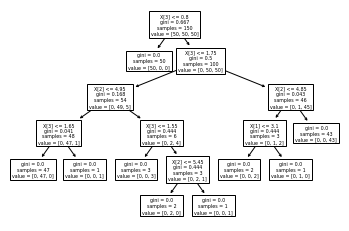

In [53]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

i = 100
print(X[i], y[i])
print(clf.predict_proba(np.atleast_2d(X[i]))[0], clf.predict(np.atleast_2d(X[i]))[0])
nodes_list = tree.plot_tree(clf)
nodes_list

In [54]:
#tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
#model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')